In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import pickle

from LR import *

# plotting parameters
mpl.rcParams['font.serif'] = "Times New Roman"
mpl.rcParams["figure.figsize"] = [3.25,3.25]
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rc('text', usetex='true') 
mpl.rc('font', family='serif') 

plt.rcParams.update({'font.size': 8, 'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'})

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.titlesize'] = 18

d = 20                                    # dimension of domain (number of columns of the matrix A)
n = 10*d                                  # number of samples (number of rows of the matrix A)
T = 600                                   # number of steps (horizon)
mu = 1                                    # strong convexity parameter of LR objectives
x_0 = np.random.normal(size=d)            # initial point for SGD
N = 100                                   # number of trials for computing empirical average

In [2]:
A = np.random.normal(loc=0, scale=1, size=(n,d))      # matrix for LR objectives
v = norm(A, axis = 1)                                 # vector of row-norms of A
M = np.amax(v)                                        # largest row-norm of A
Delta = M/(mu*n)                                      # minimizer drift parameter
B = M/n                                               # gradient drift parameter (mu*Delta)
L = (norm(A,ord=2)**2)/(4*n) + mu                     # smoothness parameter for LR objectives

In [3]:
sigma = np.sqrt(((n-2)/n**2)*np.sum(v**2) + (1/n**2)*np.sum(np.outer(v,v)))  # sample gradient variance bound
# sigma = np.sqrt(2)*M                                                       # sample gradient variance bound (looser)
eta = eta_opt1(mu, L, sigma, Delta)                                          # asymptotically optimal step size for distance tracking error

In [4]:
print(Delta, sigma, np.sqrt(2)*M, L, eta, 1/(2*L))

0.03208770874080578 6.270998871623811 9.075774577345049 1.4124308177074807 0.03741203409046603 0.35399963929670625


In [5]:
b_init = np.random.randint(0,2,n)             # initial n-dimensional label vector of 0's and 1's
x_init = mins(A, labels(b_init, T), mu)[0]    # initial LR minimizer corresponding to A, b_init, and mu

In [6]:
a1_LR = trckerr1trials(T, b_init, mu, A, x_0, eta, sigma, N)       # distance tracking errors (N trials)
a2_LR = asymptbd1(mu, eta, sigma, Delta)                           # asymptotic bound (noise + drift)
a3_LR = opterr1(mu, eta, x_0, x_init, T) + a2_LR                   # guaranteed bound (optimization + noise + drift)

In [7]:
def NinetyFive_CI(data):
    a = 1.0 * np.array(data)
    m = np.mean(a)
    h = 2*np.std(a)
    return m-h, m, m+h

Text(19.042358246419674, 0.5, '$ \\mathbb{E} \\|x_t - x_t^\\star\\|^2$')

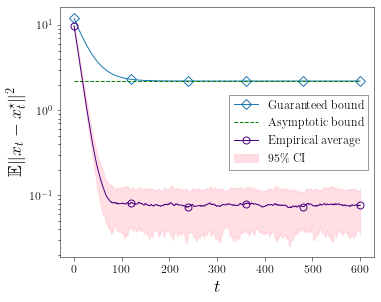

In [8]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
fig.tight_layout(pad=1)

# 95% confidence interval data
m0 = [NinetyFive_CI(a1_LR[k]) for k in range(a1_LR.shape[0])]
m = np.stack(m0, axis=0)

# plot a1_LR (with 95% confidence interval), a2_LR, a3_LR
axes.semilogy(a3_LR, label='Guaranteed bound', color='tab:blue', linestyle='-', marker='D', markerfacecolor='none', markevery=int((T+1)/5))
axes.semilogy(a2_LR*np.ones(T+1), label='Asymptotic bound', color='green', linestyle='--')
fillcolor = 'pink'
linecolor = 'indigo'
axes.semilogy(m[:,1], color=linecolor, marker = 'o', markerfacecolor='none', markevery=int((T+1)/5), label='Empirical average')
axes.fill_between(np.arange(0,T+1), m[:,0], m[:,2], alpha=0.5,edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
axes.tick_params(width=.5)

# set up legend
leg = axes.legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)

# label axes
plt.xlabel(r'$t$')
plt.ylabel(r'$ \mathbb{E} \|x_t - x_t^\star\|^2$')

In [9]:
with open('plot1_LR.p', 'wb') as f:
    pickle.dump([a1_LR, a2_LR, a3_LR], f)

In [10]:
def func1(mu):         # N trials of distance tracking error at horizon T as a function of mu
    return trckerr1trials(T, b_init, mu, A, x_0, eta_opt1(mu, (norm(A,ord=2)**2)/(4*n) + mu, sigma, M/(mu*n)), sigma, N)[T]
def bdfunc1(mu):       # guaranteed bound on distance tracking error at horizon T as a function of mu
    return opterr1(mu, eta_opt1(mu, (norm(A,ord=2)**2)/(4*n) + mu, sigma, M/(mu*n)), x_0, x_init, T)[T] + asymptbd1(mu, eta_opt1(mu, (norm(A,ord=2)**2)/(4*n) + mu, sigma, M/(mu*n)), sigma, M/(mu*n))

In [11]:
u0 = np.linspace(.02,20,40)
s0 = np.array([func1(u) for u in u0])
r0 = np.array([bdfunc1(u) for u in u0])

Text(19.042358246419674, 0.5, '$\\mathbb{E}\\|x_T - x_T^\\star\\|^2$')

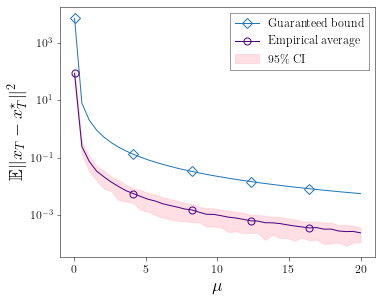

In [12]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
fig.tight_layout(pad=1)

# 95% confidence interval data
m0 = [NinetyFive_CI(s0[k]) for k in range(s0.shape[0])]
m = np.stack(m0, axis=0)

# plot r0 and s0 (with 95% confidence interval)
axes.semilogy(u0, r0, color='tab:blue', marker='D', markerfacecolor='none', markevery=8, label='Guaranteed bound')
fillcolor = 'pink'
linecolor = 'indigo'
axes.semilogy(u0, m[:,1], color=linecolor, marker = 'o', markerfacecolor='none', markevery=8, label='Empirical average')
axes.fill_between(u0, m[:,0], m[:,2], alpha=0.5,edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
axes.tick_params(width=.5)

# set up legend
leg = axes.legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)

# label axes
plt.xlabel(r'$ \mu$')
plt.ylabel(r'$\mathbb{E}\|x_T - x_T^\star\|^2$')

In [13]:
with open('plot2_LR.p', 'wb') as f:
    pickle.dump([u0, s0, r0], f)

In [14]:
def stepfunc1(eta):         # N trials of distance tracking error at horizon T as a function of eta
    return trckerr1trials(T, b_init, mu, A, x_0, eta, sigma, N)[T]
def bdstepfunc1(eta):       # guaranteed bound on distance tracking error at horizon T as a function of eta
    return opterr1(mu, eta, x_0, x_init, T)[T] + asymptbd1(mu, eta, sigma, Delta)

In [15]:
u00 = np.linspace(.001,1/(2*L),40)
s00 = np.array([stepfunc1(u) for u in u00])
r00 = np.array([bdstepfunc1(u) for u in u00])

In [16]:
eta1 = eta_opt1(mu, L, sigma, Delta)  

Text(19.042358246419674, 0.5, '$\\mathbb{E}\\|x_T - x_T^\\star\\|^2$')

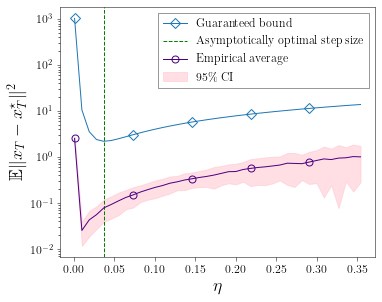

In [17]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
fig.tight_layout(pad=1)

# 95% confidence interval data
m0 = [NinetyFive_CI(s00[k]) for k in range(s00.shape[0])]
m = np.stack(m0, axis=0)

# plot r00, eta1, and s00 (with 95% confidence interval)
axes.semilogy(u00, r00, color='tab:blue', marker='D', markerfacecolor='none', markevery=8, label='Guaranteed bound')
axes.axvline(x = eta1, color='green', linestyle='--', label='Asymptotically optimal step size')
fillcolor = 'pink'
linecolor = 'indigo'
axes.semilogy(u00, m[:,1], color=linecolor, marker = 'o', markerfacecolor='none', markevery=8, label='Empirical average')
axes.fill_between(u00, m[:,0], m[:,2], alpha=0.5,edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
axes.tick_params(width=.5)

# set up legend
leg = axes.legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)

# label axes
plt.xlabel(r'$ \eta$')
plt.ylabel(r'$\mathbb{E}\|x_T - x_T^\star\|^2$')

In [18]:
with open('plot3_LR.p', 'wb') as f:
    pickle.dump([u00, s00, r00, eta1], f)

In [19]:
eta = eta_opt2(mu, L, sigma, B)   # asymptotically optimal step size for function gap tracking error

In [20]:
b1_LR = trckerr2trials(T, b_init, mu, A, x_0, eta, sigma, N)          # function gap tracking errors (N trials)
b2_LR = asymptbd2(mu, eta, sigma, B)                                  # asymptotic bound (noise + drift)
b3_LR = empopterr2bd(mu, eta, x_0, A, b_init, x_init, T) + b2_LR      # guaranteed bound

Text(19.042358246419674, 0.5, '$\\mathbb{E}[\\varphi_t(\\hat{x}_t) - \\varphi_t^\\star]$')

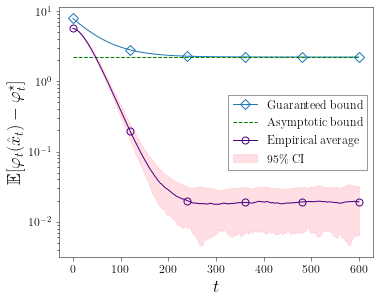

In [21]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
fig.tight_layout(pad=1)

# 95% confidence interval data
m0 = [NinetyFive_CI(b1_LR[k]) for k in range(b1_LR.shape[0])]
m = np.stack(m0, axis=0)

# Plot b1_LR (with 95% confidence interval), b2_LR, b3_LR
axes.semilogy(b3_LR, label='Guaranteed bound', color='tab:blue', linestyle='-', marker='D', markerfacecolor='none', markevery=int((T+1)/5))
axes.semilogy(b2_LR*np.ones(T+1), label='Asymptotic bound', color='green', linestyle='--')
fillcolor = 'pink'
linecolor = 'indigo'
axes.semilogy(m[:,1], color=linecolor, marker = 'o', markerfacecolor='none', markevery=int(T/5), label='Empirical average')
axes.fill_between(np.arange(0,T+1), m[:,0], m[:,2], alpha=0.5,edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
axes.tick_params(width=.5)

# set up legend
leg = axes.legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)

# label axes
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[\varphi_t(\hat{x}_t) - \varphi_t^\star]$')

In [22]:
with open('plot4_LR.p', 'wb') as f:
    pickle.dump([b1_LR, b2_LR, b3_LR], f)

In [23]:
def func2(mu):         # N trials of function gap tracking error at horizon T as a function of mu
    return trckerr2trials(T, b_init, mu, A, x_0, eta_opt2(mu, (norm(A,ord=2)**2)/(4*n) + mu, sigma, B), sigma, N)[T]
def bdfunc2(mu):       # predicted bound on function gap tracking error at horizon T as a function of mu
    return empopterr2bd(mu, eta_opt2(mu, (norm(A,ord=2)**2)/(4*n) + mu, sigma, B), x_0, A, b_init, x_init, T)[T] + asymptbd2(mu, eta_opt2(mu, (norm(A,ord=2)**2)/(4*n) + mu, sigma, B), sigma, B)

In [24]:
u1 = np.linspace(.02,20,40)
s1 = np.array([func2(u) for u in u1])
r1 = np.array([bdfunc2(u) for u in u1])

Text(19.042358246419674, 0.5, '$\\mathbb{E}[\\varphi_T(\\hat{x}_T) - \\varphi_T^\\star]$')

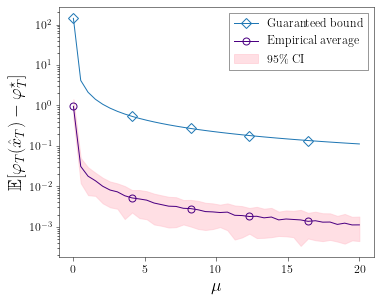

In [25]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
fig.tight_layout(pad=1)

# 95% confidence interval data
m0 = [NinetyFive_CI(s1[k]) for k in range(s1.shape[0])]
m = np.stack(m0, axis=0)

# plot r1 and s1 (with 95% confidence interval)
axes.semilogy(u1, r1, color='tab:blue', marker='D', markerfacecolor='none', markevery=8, label='Guaranteed bound')
fillcolor = 'pink'
linecolor = 'indigo'
axes.semilogy(u1, m[:,1], color=linecolor, marker = 'o', markerfacecolor='none', markevery=8, label='Empirical average')
axes.fill_between(u1, m[:,0], m[:,2], alpha=0.5, edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
axes.tick_params(width=.5)

# set up legend
leg = axes.legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)

# label axes
plt.xlabel(r'$ \mu$')
plt.ylabel(r'$\mathbb{E}[\varphi_T(\hat{x}_T) - \varphi_T^\star]$')

In [26]:
with open('plot5_LR.p', 'wb') as f:
    pickle.dump([u1, s1, r1], f)

In [27]:
def stepfunc2(eta):         # N trials of function gap tracking error at horizon T as a function of eta
    return trckerr2trials(T, b_init, mu, A, x_0, eta, sigma, N)[T]
def bdstepfunc2(eta):       # predicted bound on function gap tracking error at horizon T as a function of eta
    return empopterr2bd(mu, eta, x_0, A, b_init, x_init, T)[T] + asymptbd2(mu, eta, sigma, B)

In [28]:
u11 = np.linspace(.001,1/(2*L),40)
s11 = np.array([stepfunc2(u) for u in u11])
r11 = np.array([bdstepfunc2(u) for u in u11])

In [29]:
eta2 = eta_opt2(mu, L, sigma, B)

Text(19.042358246419674, 0.5, '$\\mathbb{E}[\\varphi_T(\\hat{x}_T) - \\varphi_T^\\star]$')

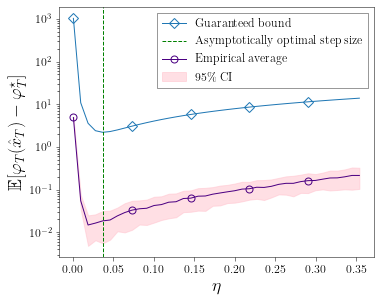

In [30]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
fig.tight_layout(pad=1)

# 95% confidence interval data
m0 = [NinetyFive_CI(s11[k]) for k in range(s11.shape[0])]
m = np.stack(m0, axis=0)

# plot r11, eta2, and s11 (with 95% confidence interval)
axes.semilogy(u11, r11, color='tab:blue', marker='D', markerfacecolor='none', markevery=8, label='Guaranteed bound')
axes.axvline(x = eta2, color='green', linestyle='--', label='Asymptotically optimal step size')
fillcolor = 'pink'
linecolor = 'indigo'
axes.semilogy(u11, m[:,1], color=linecolor, marker = 'o', markerfacecolor='none', markevery=8, label='Empirical average')
axes.fill_between(u11, m[:,0], m[:,2], alpha=0.5,edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
axes.tick_params(width=.5)

# set up legend
leg = axes.legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)

# label axes
plt.xlabel(r'$ \eta$')
plt.ylabel(r'$\mathbb{E}[\varphi_T(\hat{x}_T) - \varphi_T^\star]$')

In [31]:
with open('plot6_LR.p', 'wb') as f:
    pickle.dump([u11, s11, r11, eta2], f)